In [1]:
import pickle

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from iminuit import Minuit
from iminuit.cost import LeastSquares
from plotly.subplots import make_subplots

import qubic.lib.Calibration.Qfiber as ft

plt.style.use("seaborn-v0_8-whitegrid")

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# If True, allow plots for debug
DEBUG = False

In [3]:
# Distances during experiment
distance_base_antenna1 = np.array([10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1]) * 0.60
distance_antenna1_antenna2 = np.array([7, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 2, 3, np.sqrt(2), np.sqrt(3), 2, 1]) * 0.60

if distance_base_antenna1.size != distance_antenna1_antenna2.size:
    print(distance_base_antenna1.size, distance_antenna1_antenna2.size)
    raise ValueError("The two arrays must have the same size")

In [4]:
print("Number of configurations: ", distance_base_antenna1.size)

Number of configurations:  41


# Import data

In [5]:
dict_data = pickle.load(open("GPS_noise_analysis.pkl", "rb"))

data_names = np.array(["rpN", "rpE", "rpD", "roll", "yaw"])
names = ["rpN", "rpE", "rpD", "roll", "yaw"]

distance_base_antenna2 = np.zeros(distance_base_antenna1.size)
for i in range(distance_base_antenna1.size):
    distance_base_antenna2[i] = np.sqrt(
        (np.mean(np.array(dict_data["rpN"]["clean_data"][i])) ** 2) + (np.mean(np.array(dict_data["rpE"]["clean_data"][i])) ** 2) + (np.mean(np.array(dict_data["rpD"]["clean_data"][i])) ** 2)
    )

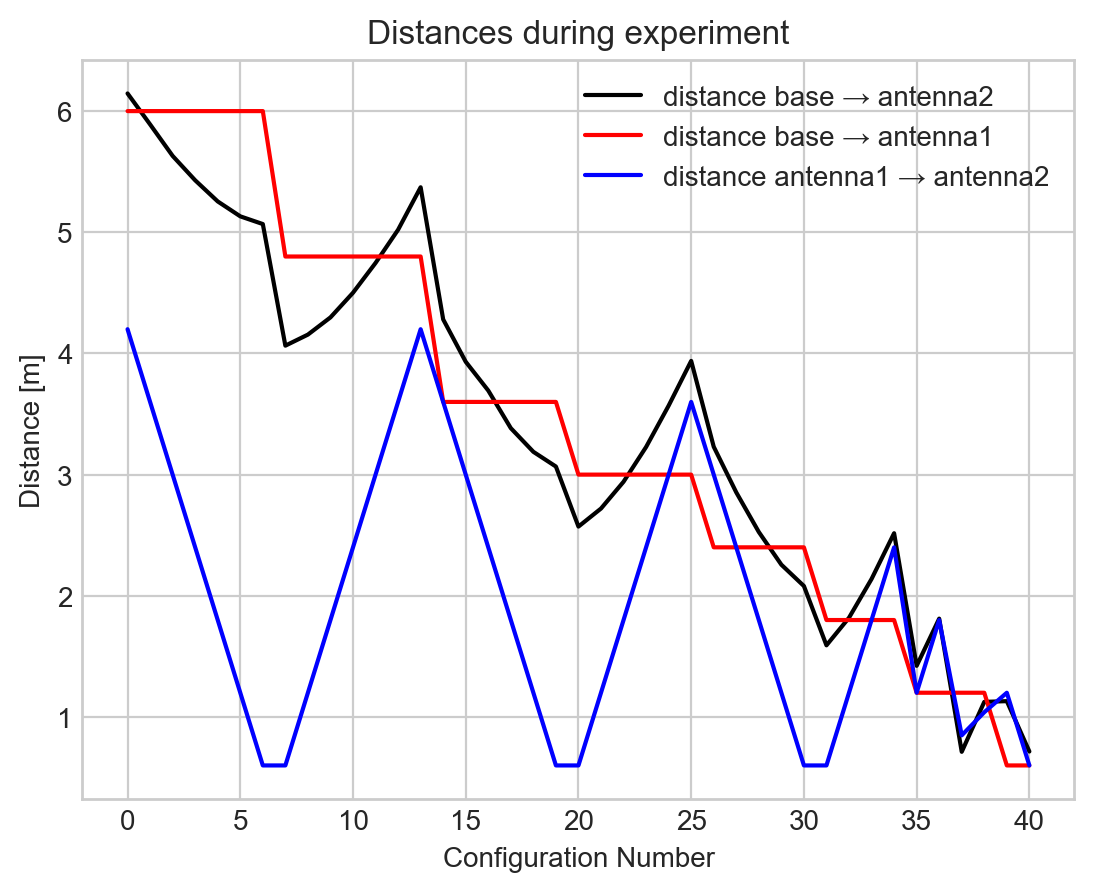

In [6]:
plt.figure(dpi=200)

plt.plot(distance_base_antenna2, label="distance base → antenna2", color="black", linestyle="-")
plt.plot(distance_base_antenna1, label="distance base → antenna1", color="red", linestyle="-")
plt.plot(distance_antenna1_antenna2, label="distance antenna1 → antenna2", color="blue", linestyle="-")

plt.xlabel("Configuration Number")
plt.ylabel("Distance [m]")
plt.title("Distances during experiment")
plt.legend()

In [7]:
print(dict_data.keys())
print(dict_data["rpN"].keys())
print(dict_data["rpN"]["clean_data"].__len__())
print(dict_data["rpN"]["clean_data"][0].size)

dict_keys(['rpN', 'rpE', 'rpD', 'roll', 'yaw', 'datetime', 'datetime_clean'])
dict_keys(['data', 'clean_data', 'ps', 'freq'])
41
2083


# Sandard Deviation

In [8]:
std_gps = np.zeros((5, len(dict_data["rpN"]["clean_data"])))

for idata in range(5):
    for jindex in range(len(dict_data["rpN"]["clean_data"])):
        std_gps[idata, jindex] = np.std(dict_data[data_names[idata]]["clean_data"][jindex])

std_gps[:2] *= 100  # Convert to cm
std_gps[2:] = np.degrees(std_gps[2:])  # Convert to deg

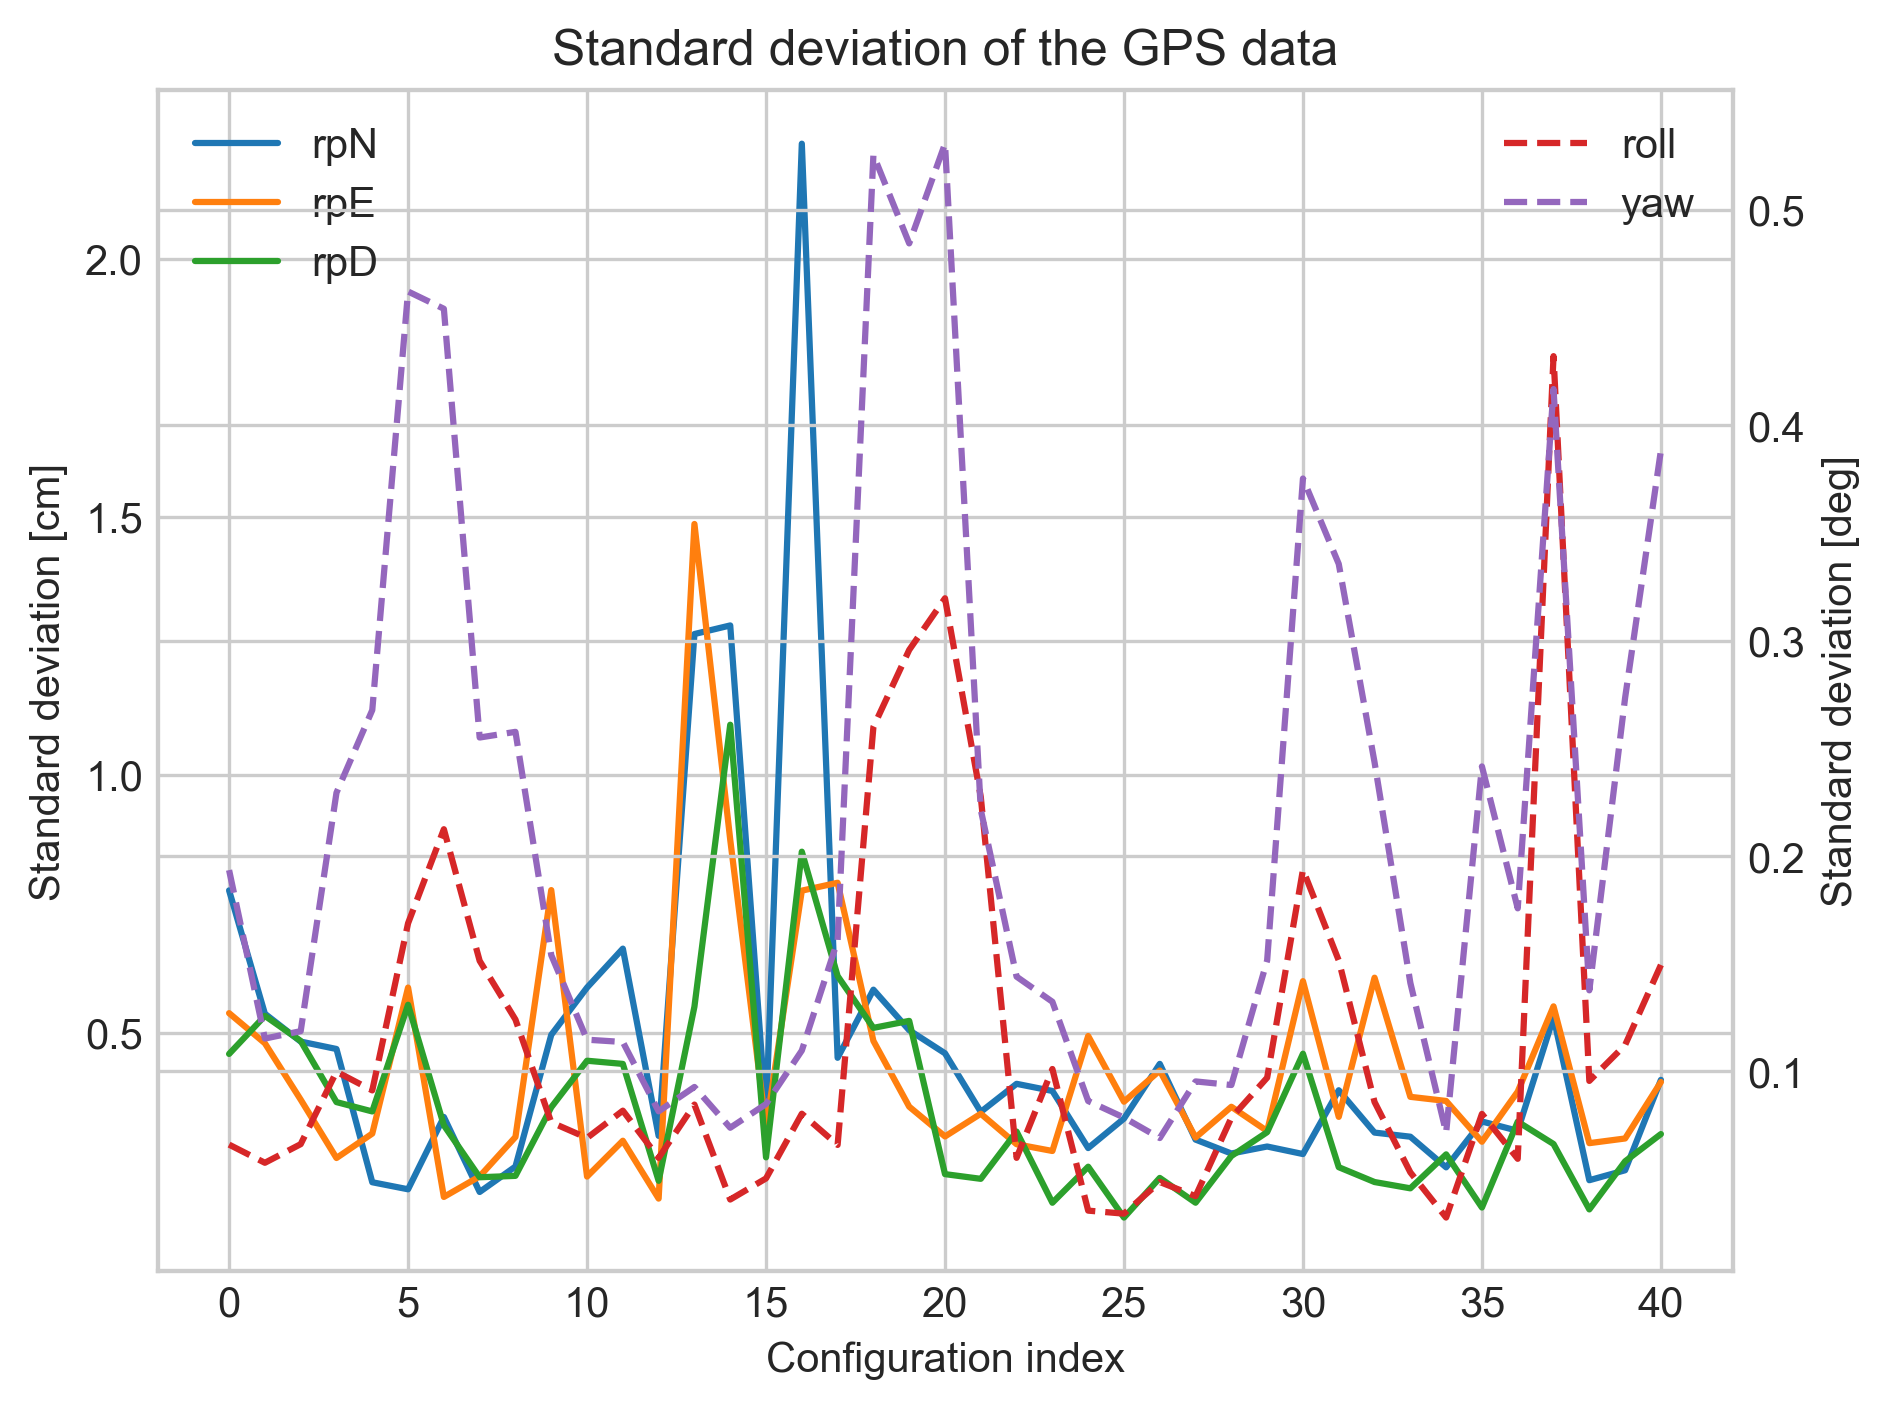

In [9]:
fig, ax1 = plt.subplots(dpi=300)

ax2 = ax1.twinx()

colors1 = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green
colors2 = ["#d62728", "#9467bd"]  # Red, Purple

for i in range(5):
    if i < 3:
        ax1.plot(std_gps[i], label=data_names[i], color=colors1[i])
    else:
        ax2.plot(std_gps[i], label=data_names[i], color=colors2[i - 3], linestyle="--")
ax1.set_ylabel("Standard deviation [cm]")
ax2.set_ylabel("Standard deviation [deg]")
ax1.set_xlabel("Configuration index")
ax1.set_title("Standard deviation of the GPS data")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()

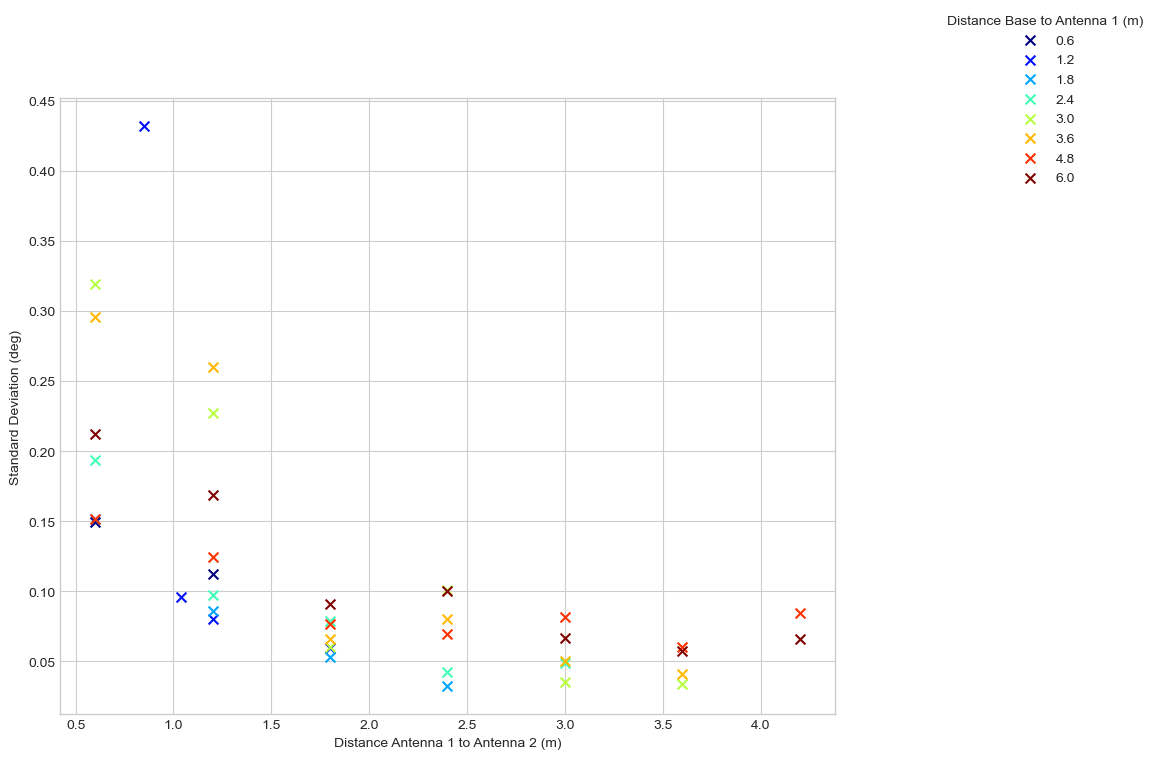

In [10]:
unique_distances = np.unique(distance_base_antenna1)
colors = cm.jet(np.linspace(0, 1, len(unique_distances)))
data_name = "roll"
index_data = names.index(data_name)

fig, ax = plt.subplots(1, 1, figsize=(10, 8), sharex=True)
for i, dist in enumerate(unique_distances):
    mask = distance_base_antenna1 == dist
    ax.scatter(distance_antenna1_antenna2[mask], std_gps[index_data, mask], label=f"{dist:.1f}", color=colors[i], marker="x", s=50)

ax.set_ylabel("Standard Deviation (deg)")
ax.set_xlabel("Distance Antenna 1 to Antenna 2 (m)")


# Create a single legend outside the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1), title="Distance Base to Antenna 1 (m)")

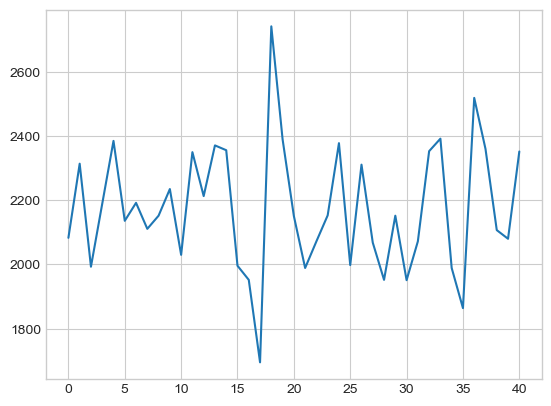

In [11]:
list_N_data_congig = [len(dict_data[data_name]["clean_data"][i]) for i in range(len(dict_data[data_name]["clean_data"]))]
plt.plot(list_N_data_congig)

In [12]:
mask

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

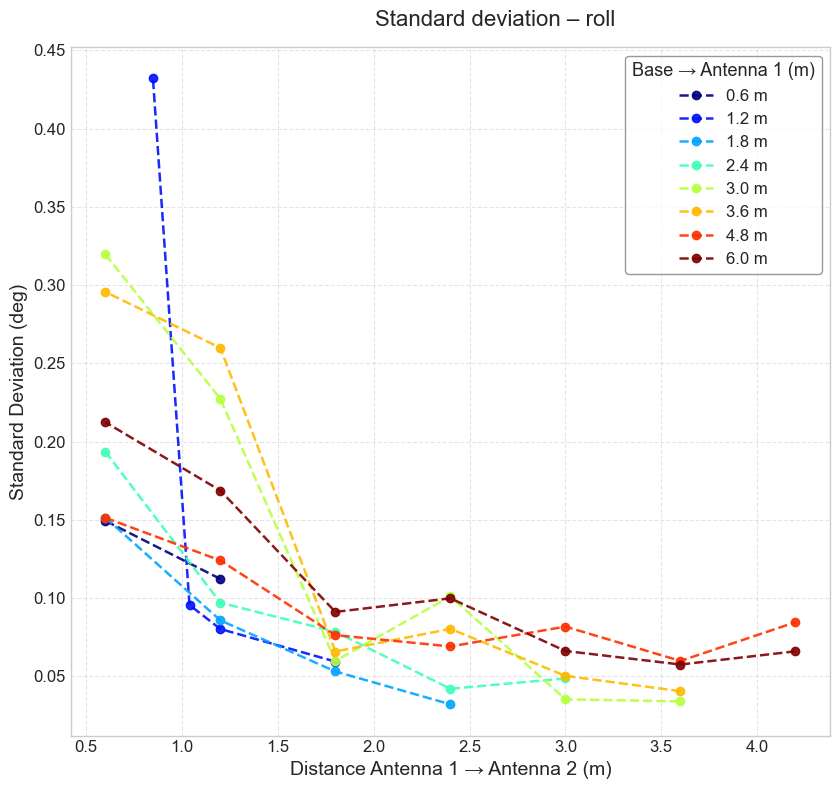

In [13]:
data_name = "roll"
index_data = names.index(data_name)

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 8)) #, dpi=300)

if data_name in ("roll", "yaw"):
    x = distance_antenna1_antenna2.copy()
    grouping = distance_base_antenna1
    x_label = "Distance Antenna 1 → Antenna 2 (m)"
    legend_title = "Base → Antenna 1 (m)"
    y_label = "Standard Deviation (deg)"
else:
    x = distance_base_antenna1.copy()
    grouping = distance_antenna1_antenna2
    x_label = "Distance Base → Antenna 1 (m)"
    legend_title = "Antenna 1 → Antenna 2 (m)"
    y_label = "Standard Deviation (cm)"

y = std_gps[index_data].copy()

# Swap axes for coherence
x[[35, 36, 37, 38]] = x[[36, 35, 38, 37]]
y[[35, 36, 37, 38]] = y[[36, 35, 38, 37]]

unique_dists = np.unique(grouping)
colors = plt.get_cmap("jet")(np.linspace(0, 1, len(unique_dists)))

for dist, c in zip(unique_dists, colors):
    mask = grouping == dist
    xs = x[mask]
    ys = y[mask]
    yerror = ys / np.sqrt(2 * len(dict_data[data_name]["clean_data"][i]))

    ax.plot(xs, ys, label=f"{dist:.1f} m", color=c, linestyle="--", linewidth=1.8, marker="o", markersize=6, alpha=0.9)

    # ax.errorbar(xs, ys, yerr=yerror, fmt="none", ecolor=c, capsize=4, elinewidth=1)

ax.set_xlabel(x_label, fontsize=14)
ax.set_ylabel(y_label, fontsize=14)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.grid(True, linestyle="--", alpha=0.5)

leg = ax.legend(#bbox_to_anchor=(0.6, 0.75), 
                loc="best", title=legend_title, fontsize=12, title_fontsize=13, frameon=True)
leg.get_frame().set_edgecolor("gray")

fig.suptitle(f"Standard deviation – {data_name}", fontsize=16, y=0.98)
fig.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

# Noise Power Spectrum

## Def useful functions

In [14]:
timestep = 0.125
print("Timestep : ", timestep, "s.")


def get_ps(array):
    """Function to compute the power spectrum of a given array.

    Parameters
    ----------
    array : array_like
        array containing the data to compute the power spectrum of.

    Returns
    -------
    power_spectrum : array_like
        array containing the power spectrum of the input array.
    freq: array_like
        array containing the frequency of the power spectrum.
    """
    N = array.size
    
    freq = np.fft.rfftfreq(N, d=timestep)
    
    P = np.abs(np.fft.rfft(array))**2
    norm_factor = 1 / (N * timestep)  # Normalization factor
    return norm_factor * P, freq

Timestep :  0.125 s.


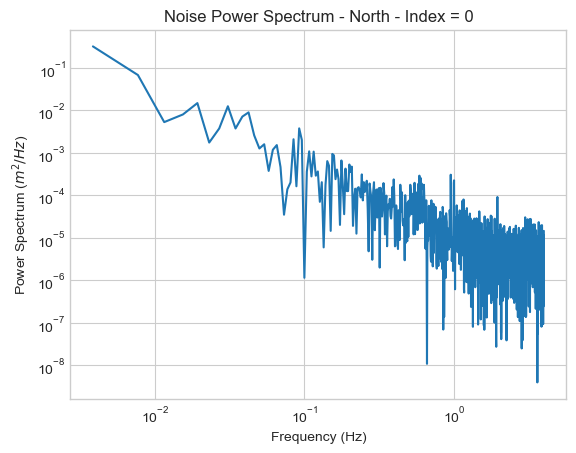

In [15]:
power_spectrum, freq = get_ps(dict_data["rpN"]["clean_data"][0])
power_spectrum, freq = power_spectrum[1:], freq[1:]

# plt.figure(dpi=200)
plt.plot(freq, power_spectrum)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Power Spectrum ($m^2/Hz$)")
plt.xscale("log")
plt.yscale("log")
plt.title("Noise Power Spectrum - North - Index = 0")

del power_spectrum, freq

In [16]:
def noise_model(x, A_white, f_knee, alpha):
    return A_white**2 * (1 + np.abs(f_knee / x) ** alpha)
    # return A_white**2 + (f_knee / x) ** alpha

### Fit using my Gaussian LogLikelihood function with minuit

## Fit 1/f + white with minuit

In [17]:
def nll_exp(A, f_knee, alpha, f, ps):
    P_model = noise_model(f, A, f_knee, alpha)
    return np.sum(np.log(P_model) + ps / P_model)


def nll_gauss(A, f_knee, alpha, freq, ps, sigma):
    P_model = noise_model(freq, A, f_knee, alpha)
    return np.sum(0.5 * ((ps - P_model) / sigma) ** 2 + 0.5 * np.log(2 * np.pi * sigma**2))


def fit_minuit_ll(data, nbins=300, plot=False, data_name=None, index=None):
    ps, freq = get_ps(data)
    ps, freq = ps[1:], freq[1:]

    binned_freq, binned_ps, _, binned_ps_error, _ = ft.profile(freq, ps, nbins=nbins, plot=False)

    def nll_wrapper(A, f_knee, alpha):
        return nll_gauss(A, f_knee, alpha, binned_freq, binned_ps, sigma=binned_ps_error)

    least_squares = LeastSquares(binned_freq, binned_ps, binned_ps_error, model=noise_model)
    m = Minuit(least_squares, A_white=0.1, f_knee=0.1, alpha=1)
    m.limits["A_white"] = (0, None)
    m.limits["f_knee"] = (0, None)
    m.limits["alpha"] = (0, None)

    m.migrad()
    m.hesse()

    if plot:
        # plt.figure(dpi=300)
        plt.plot(freq, ps, label="data")
        plt.plot(freq, noise_model(freq, *m.values), "r", label="fit")

        # display legend with some fit info
        fit_info = [
            f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
        ]
        for p, v, e in zip(m.parameters, m.values, m.errors):
            fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
        plt.title(f"Fit on Noise Power Spectrum - {data_name} - Index {index}")
        plt.legend(title="\n".join(fit_info), frameon=False)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel(r"Power Spectrum ($m^2/Hz$)")
        plt.xscale("log")
        plt.yscale("log")
        plt.show()

    return m.values, m.errors, m.fmin.reduced_chi2

/tmp/ipykernel_696289/3369301313.py:2: RuntimeWarning: overflow encountered in power
  return A_white**2 * (1 + np.abs(f_knee / x) ** alpha)
/tmp/ipykernel_696289/3369301313.py:2: RuntimeWarning: overflow encountered in multiply
  return A_white**2 * (1 + np.abs(f_knee / x) ** alpha)


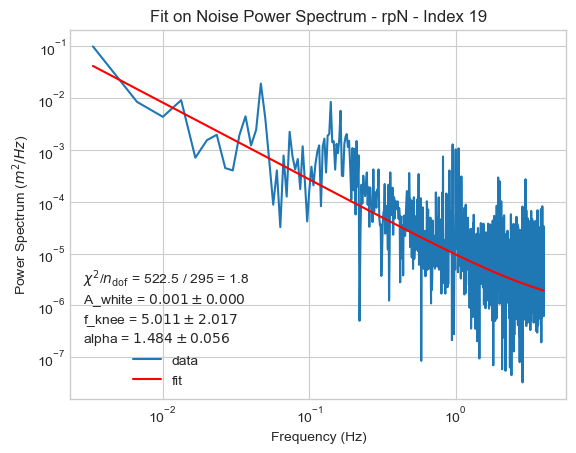

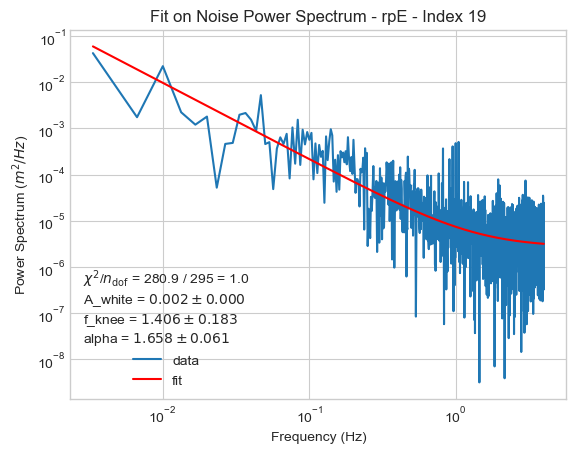

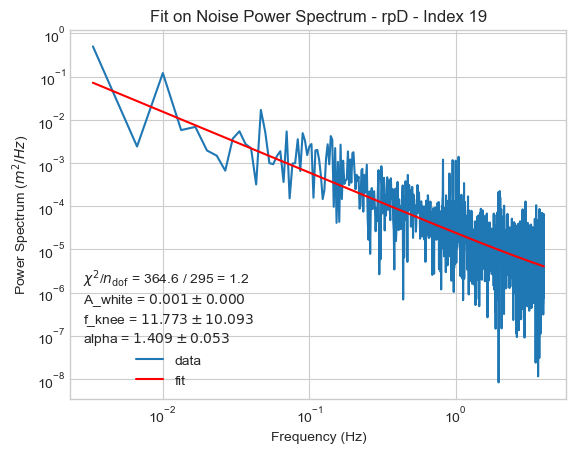

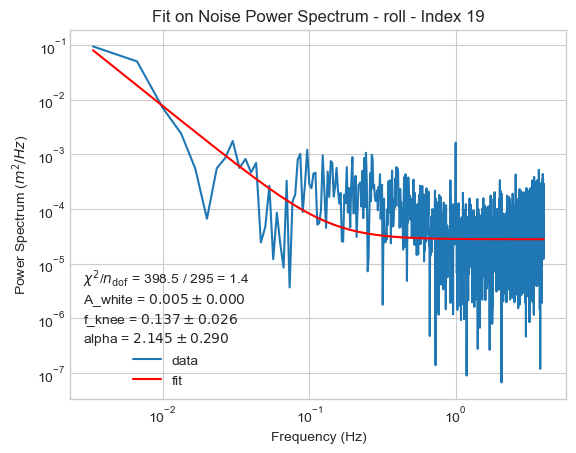

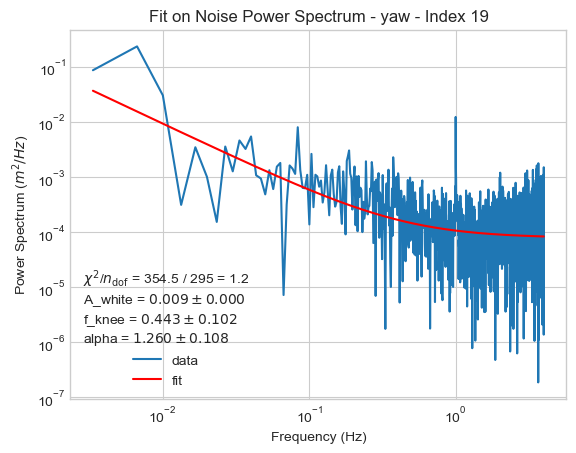

5
41
3


In [18]:
params_values_loglike, params_errors_loglike, reduced_chi2_loglike = [], [], []
names = ["rpN", "rpE", "rpD", "roll", "yaw"]
label = [r"$A_{white}$", r"$f_{knee}$", r"$\alpha$"]

# Fit for each instrumental configurations
for idata in range(len(names)):
    values, errors, chi2_dof = [], [], []
    for index in range(len(dict_data["rpN"]["clean_data"])):
        if index == 19:
            plot = True
        else:
            plot = False
        val, err, red_chi2 = fit_minuit_ll(
            dict_data[names[idata]]["clean_data"][index], nbins=int(dict_data[names[idata]]["clean_data"][index].size / 8), plot=plot, data_name=names[idata], index=index
        )
        values.append(val)
        errors.append(err)
        chi2_dof.append(red_chi2)
    params_values_loglike.append(values)
    params_errors_loglike.append(errors)
    reduced_chi2_loglike.append(chi2_dof)

print(len(params_values_loglike))
print(len(params_values_loglike[0]))
print(len(params_values_loglike[0][0]))

## Plot fitted parameters

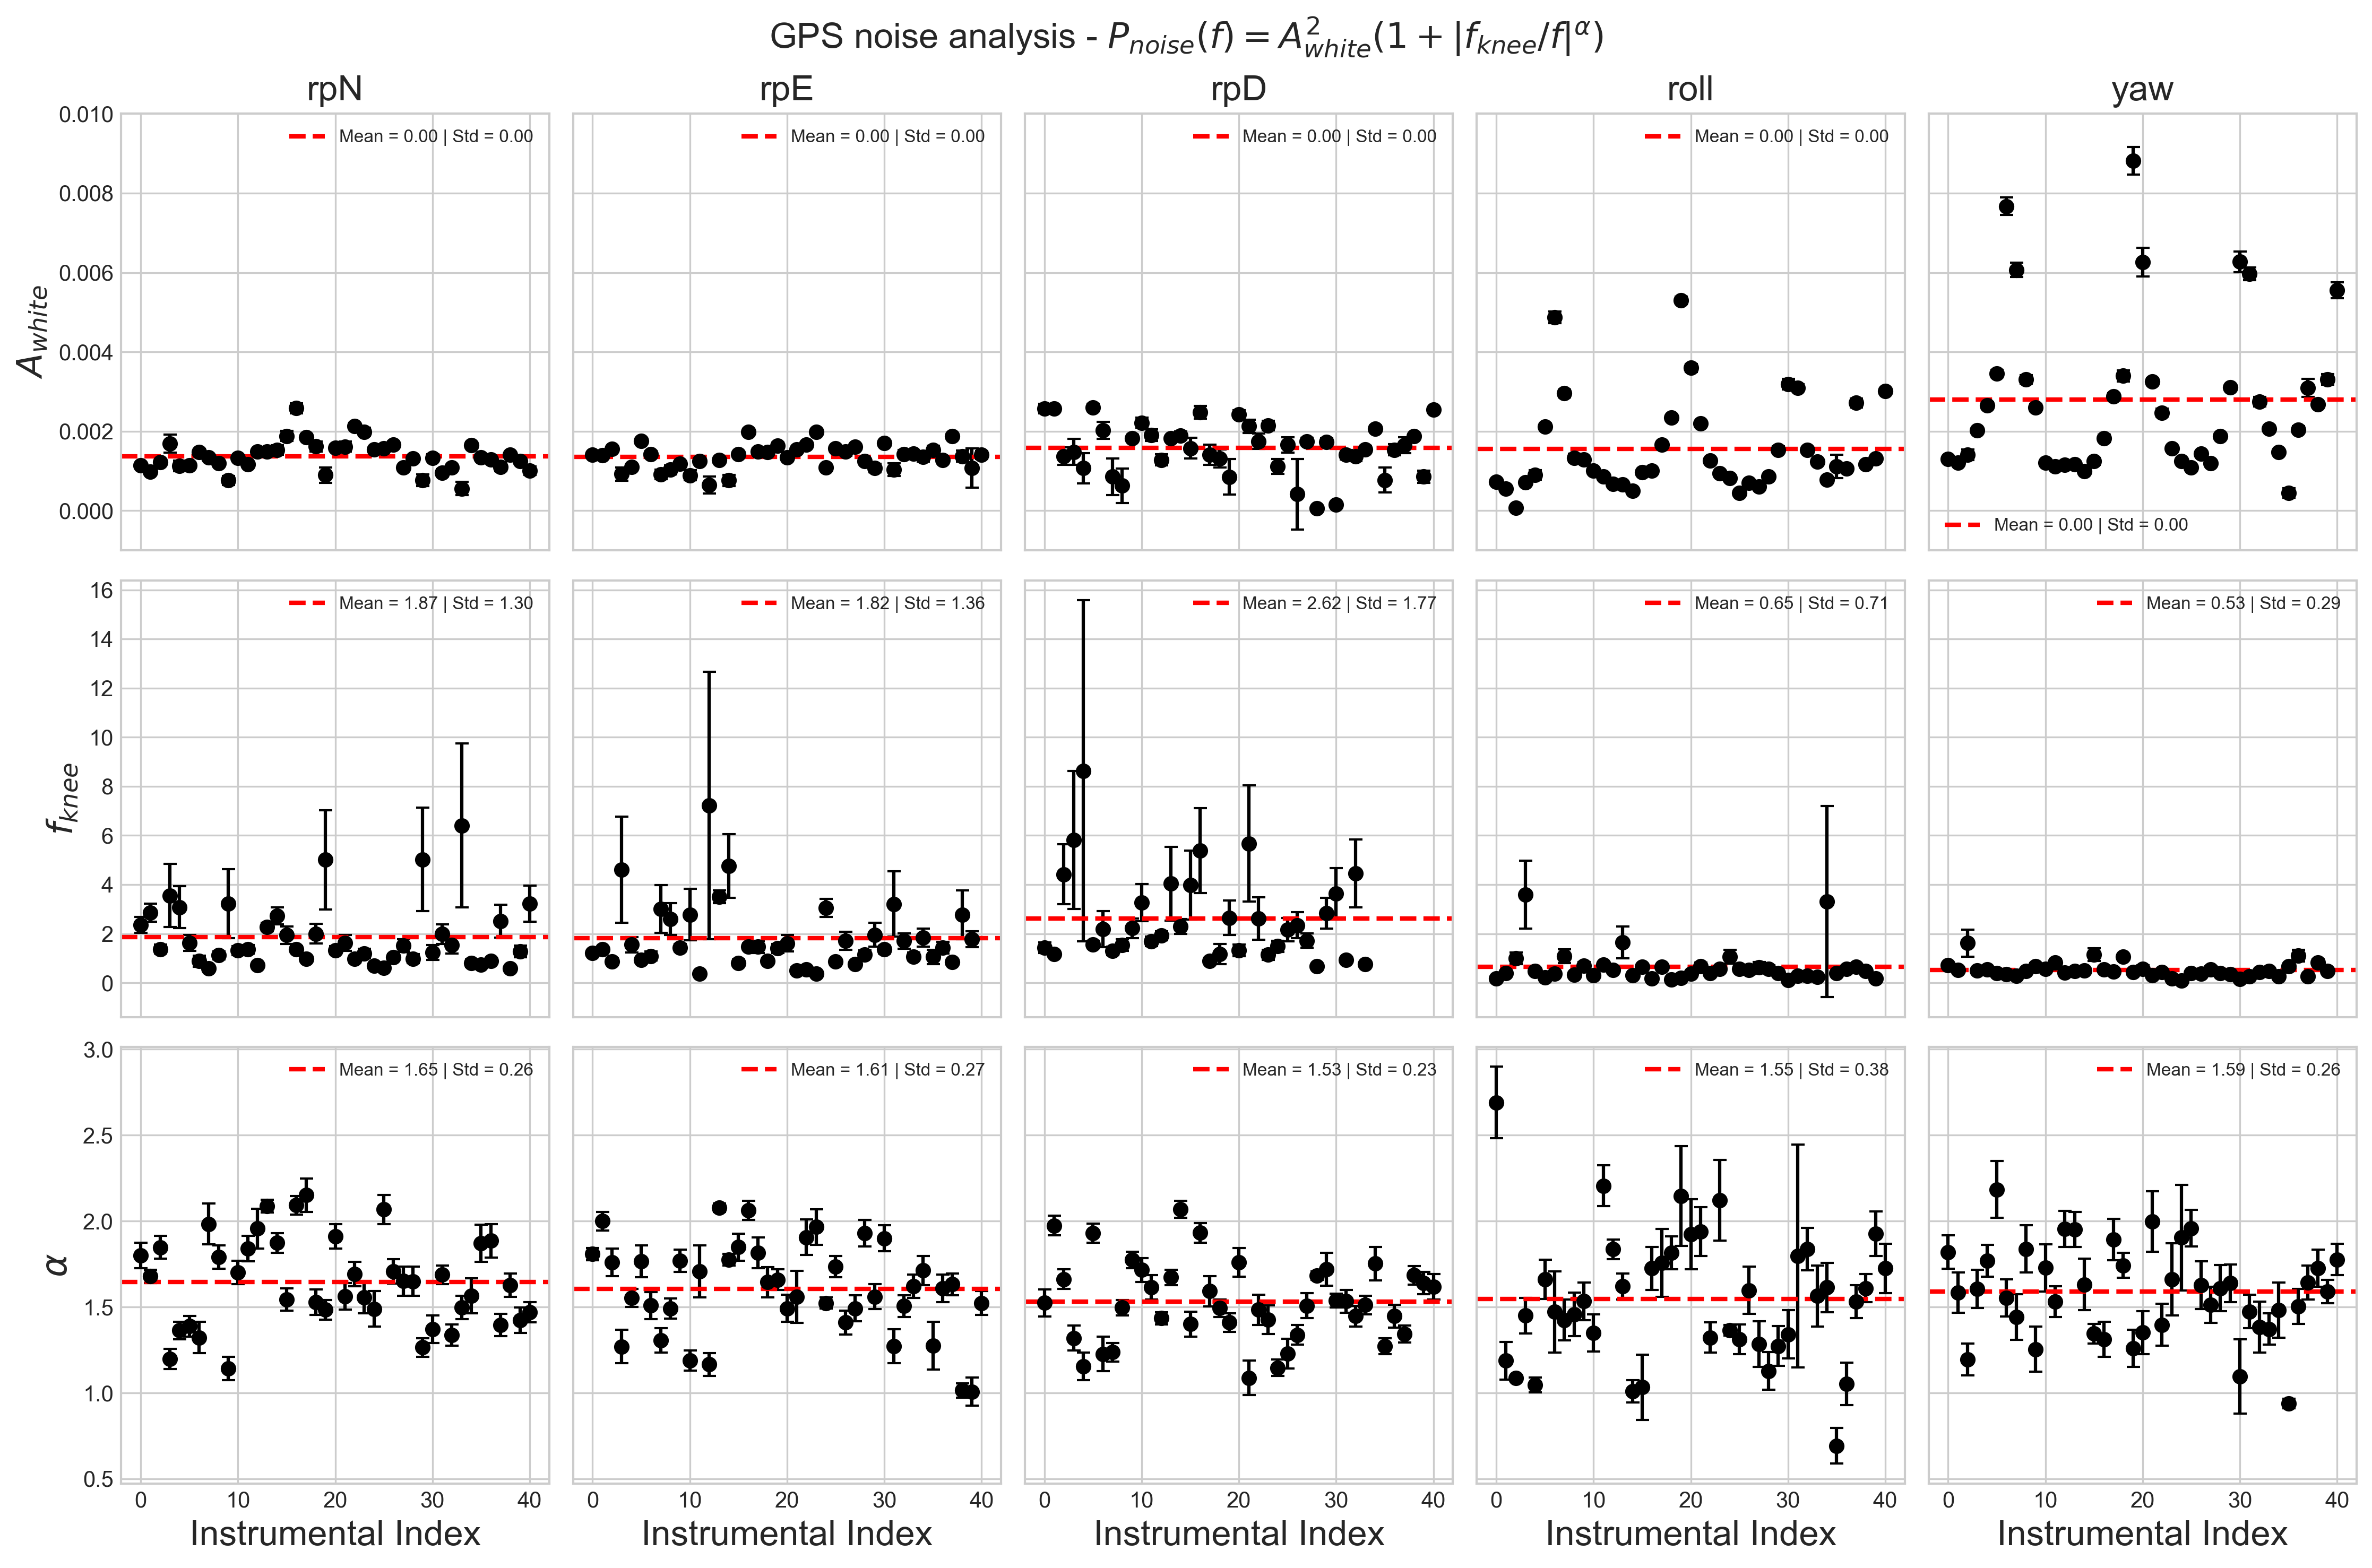

In [19]:
fig, ax = plt.subplots(3, 5, figsize=(15, 10), sharey="row", sharex=True, dpi=300)

n_datasets = len(names)
n_points = len(params_values_loglike[0])
for idata in range(n_datasets):
    for iparam in range(3):
        values = np.array([params_values_loglike[idata][i][iparam] for i in range(n_points)])
        errors = [params_errors_loglike[idata][i][iparam] for i in range(n_points)]
        if iparam == 1:
            mask = values < 10
            values = values[mask]
            errors = np.array(errors)[mask]
        else:
            values = values
            errors = np.array(errors)

        x = np.arange(values.shape[0])
        ax[iparam, idata].errorbar(x, values, yerr=errors, fmt="o", color="black", capsize=3)

        mean_val = np.mean(values)
        std_val = np.std(values)
        ax[iparam, idata].axhline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.2f} | Std = {std_val:.2f}")
        ax[iparam, idata].legend(fontsize=8)

for iparam in range(3):
    ax[iparam, 0].set_ylabel(label[iparam], fontsize=16)

for idata in range(n_datasets):
    ax[0, idata].set_title(names[idata], fontsize=16)
    ax[0, idata].set_ylim(-0.001, 0.01)
    # ax[1, idata].set_ylim(-0.01, 0.2)

for idata in range(n_datasets):
    ax[2, idata].set_xlabel("Instrumental Index", fontsize=16)
fig.suptitle(r"GPS noise analysis - $P_{noise}(f) = A_{white}^2 (1 + |f_{knee}/f|^{\alpha})$", fontsize=16)
plt.tight_layout()
plt.savefig("GPS noise analysis - over f + White.png")
plt.show()

## Are the parameters scaled with the distance between antennas ?

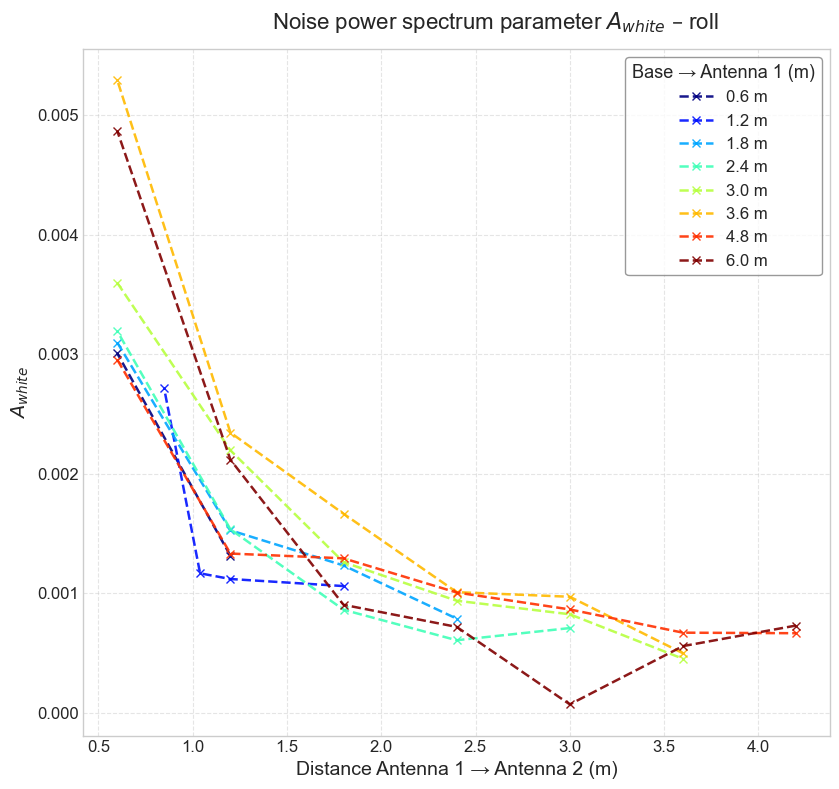

In [20]:
data_name = "roll"
index_data = names.index(data_name)
params_value = np.array(params_values_loglike, dtype=float)[index_data]

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 8)) #, dpi=300)

if data_name in ("roll", "yaw"):
    x = distance_antenna1_antenna2.copy()
    grouping = distance_base_antenna1
    x_label = "Distance Antenna 1 → Antenna 2 (m)"
    legend_title = "Base → Antenna 1 (m)"
else:
    x = distance_base_antenna1.copy()
    grouping = distance_antenna1_antenna2
    x_label = "Distance Base → Antenna 1 (m)"
    legend_title = "Antenna 1 → Antenna 2 (m)"
y = params_value[:, 0].copy()
y_label = r"$A_{white}$"

# Swap axes for coherence
x[[35, 36, 37, 38]] = x[[36, 35, 38, 37]]
y[[35, 36, 37, 38]] = y[[36, 35, 38, 37]]

# Plot by unique grouping distances
unique_dists = np.unique(grouping)
colors = cm.jet(np.linspace(0, 1, len(unique_dists)))

for dist, c in zip(unique_dists, colors):
    mask = grouping == dist
    xs = x[mask]
    ys = y[mask]
    ax.plot(xs, ys, label=f"{dist:.1f} m", color=c, linestyle="--", linewidth=1.8, marker="x", markersize=6, alpha=0.9)

# Labels, grid and title
ax.set_xlabel(x_label, fontsize=14)
ax.set_ylabel(y_label, fontsize=14)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.grid(True, linestyle="--", alpha=0.5)
fig.suptitle(f"Noise power spectrum parameter $A_{{white}}$ – {data_name}", fontsize=16, y=0.98)

# Legend outside
leg = ax.legend(
    # bbox_to_anchor=(0.6, 0.92),
    loc="best",
    title=legend_title,
    fontsize=12,
    title_fontsize=13,
    frameon=True,
)
leg.get_frame().set_edgecolor("gray")

fig.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


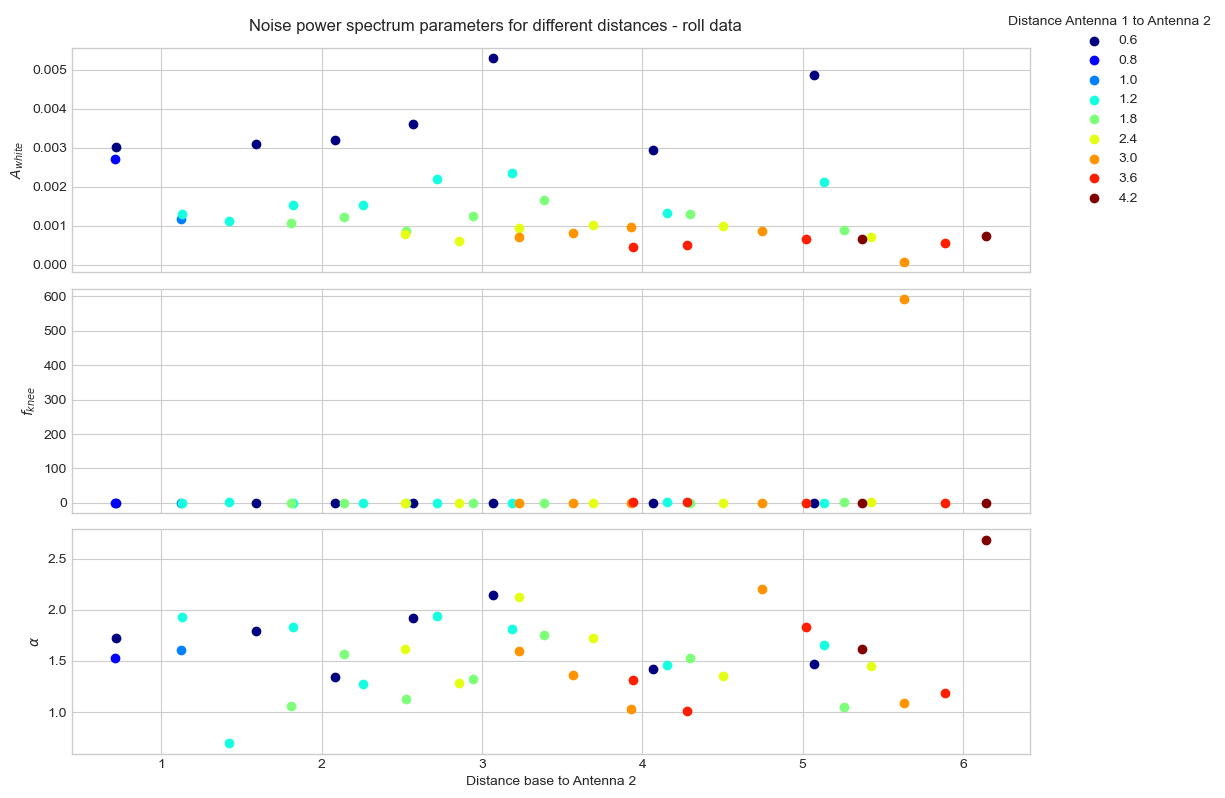

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)  # , dpi=300)

unique_distances = np.unique(distance_antenna1_antenna2)
colors = cm.jet(np.linspace(0, 1, len(unique_distances)))

for i, dist in enumerate(unique_distances):
    mask = distance_antenna1_antenna2 == dist
    ax[0].scatter(distance_base_antenna2[mask], params_value[mask, 0], label=f"{dist:.1f}", color=colors[i])
    ax[1].scatter(distance_base_antenna2[mask], params_value[mask, 1], color=colors[i])
    ax[2].scatter(distance_base_antenna2[mask], params_value[mask, 2], color=colors[i])

ax[0].set_ylabel(r"$A_{white}$")
ax[1].set_ylabel(r"$f_{knee}$")
ax[2].set_ylabel(r"$\alpha$")
ax[2].set_xlabel("Distance base to Antenna 2")

# Create a single legend outside the plot
handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc="upper left", bbox_to_anchor=(1, 1), title="Distance Antenna 1 to Antenna 2")

fig.suptitle(f"Noise power spectrum parameters for different distances - {data_name} data")
plt.tight_layout(rect=[0, 0, 1.05, 1])  # Adjust layout to make space for legend
plt.show()

# Save fitted parameters in Pickle file

In [22]:
parameters_names = np.array(["A_white", "f_knee", "alpha"])
params_values_loglike_array = np.array(params_values_loglike).transpose((2, 0, 1)) 
params_errors_loglike_array = np.array(params_errors_loglike).transpose((2, 0, 1))
reduced_chi2_loglike_array = np.array(reduced_chi2_loglike)

dict_fit = {"values": {}, "errors": {}, "reduced_chi2": {}, "standard_deviation": {}}

for idata, data_name in enumerate(data_names):
    dict_fit["values"][data_name] = {}
    dict_fit["errors"][data_name] = {}
    dict_fit["reduced_chi2"][data_name] = reduced_chi2_loglike_array[idata]
    dict_fit["standard_deviation"][data_name] = std_gps[idata]
    for iparam, param_name in enumerate(parameters_names):
        dict_fit["values"][data_name][param_name] = params_values_loglike_array[iparam, idata]
        dict_fit["errors"][data_name][param_name] = params_errors_loglike_array[iparam, idata]
        
with open("GPS_fit_results.pkl", "wb") as f:
    pickle.dump(dict_fit, f)